In [1]:
import os
import random
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score
from tqdm import tqdm
from termcolor import colored

In [2]:
# Custom dataset class for dSprites dataset
class DspritesDataset(Dataset):
    def __init__(self, npz_file):
        """
        Initializes the dSprites dataset by loading the image data and ground truth factors.

        Args:
            npz_file (str): Path to the .npz file containing the dataset.
        """
        self.data = np.load(npz_file)
        self.images = np.expand_dims(self.data['imgs'], axis=1)  # Add channel dimension for CNN
        self.latent_classes = self.data['latents_classes'][:, 1:]  # Skip the 'color' factor (always 1)
        self.latent_values = self.data['latents_values'][:, 1:]  # Skip the 'color' factor (always 1)

    def __len__(self):
        """Returns the total number of images."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Fetches an image and its corresponding ground truth factors.

        Args:
            idx (int): Index of the data sample.

        Returns:
            Tuple: Image as torch.Tensor, latent classes, and latent values.
        """
        image = torch.tensor(self.images[idx], dtype=torch.float32)  # Convert image to float32 tensor
        latent_classes = torch.tensor(self.latent_classes[idx], dtype=torch.int)  # Ground truth factors (e.g., shape, scale)
        latent_values = torch.tensor(self.latent_values[idx], dtype=torch.float32)  # Continuous values for factors

        return image, latent_classes, latent_values

# Encoder architecture
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        """
        Encoder for beta-VAE using convolutional layers.

        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(ConvEncoder, self).__init__()
        # Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU()
        )
        # Fully connected layers for mu and logvar
        self.fc1 = nn.Linear(64 * 4 * 4, 256)  # Fully connected layer with 256 units
        self.fc_mu = nn.Linear(256, latent_dim)  # Latent mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Latent log-variance

    def forward(self, x):
        """
        Forward pass for the encoder to produce latent space parameters.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log-variance of the latent space.
        """
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output of the convolution layers
        h = self.fc1(h)  # Apply fully connected layer
        mu = self.fc_mu(h)  # Mean
        logvar = self.fc_logvar(h)  # Log variance
        return mu, logvar

# Decoder architecture
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, num_channels=1):
        """
        Decoder for beta-VAE using transpose convolutional layers.

        Args:
            latent_dim (int): Dimensionality of the latent space.
            num_channels (int): Number of output image channels (1 for grayscale images).
        """
        super(ConvDecoder, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(latent_dim, 256)  # Latent dim -> 256
        self.fc2 = nn.Linear(256, 64 * 4 * 4)  # 256 -> 4x4x64
        
        # Transpose convolutional layers with adjusted padding
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # Sigmoid activation to output pixel values in range [0, 1]
        )
    
    def forward(self, z):
        """
        Forward pass for the decoder to reconstruct the image from the latent space.

        Args:
            z (torch.Tensor): Latent vector.

        Returns:
            torch.Tensor: Reconstructed image.
        """
        h = self.fc1(z)
        h = self.fc2(h)
        h = h.view(h.size(0), 64, 4, 4)  # Reshape to match convolutional layers
        return self.decoder(h)

# beta-VAE model
class BetaVAE(nn.Module):
    def __init__(self, latent_dim):
        """
        beta-VAE model with encoder and decoder networks.

        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(BetaVAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from a Gaussian distribution.

        Args:
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log-variance of the latent space.

        Returns:
            torch.Tensor: Reparameterized latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random normal noise
        return mu + eps * std

    def forward(self, x):
        """
        Forward pass for the entire VAE model.

        Args:
            x (torch.Tensor): Input image.

        Returns:
            recon_x (torch.Tensor): Reconstructed image.
            mu (torch.Tensor): Mean of the latent space.
            logvar (torch.Tensor): Log-variance of the latent space.
        """
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [3]:
def lambda_beta_vae_loss(recon_x, x, mu, logvar, beta, lambda_reg):
    """
    Computes the lambda-beta-VAE loss, which includes:
    1. Reconstruction error (BCE)
    2. KL divergence (KLD)
    3. L2 norm regularization on the difference between original and reconstructed images.

    Args:
        recon_x (torch.Tensor): Reconstructed image.
        x (torch.Tensor): Original image.
        mu (torch.Tensor): Latent mean from the encoder.
        logvar (torch.Tensor): Latent log-variance from the encoder.
        beta (float): Scaling factor for KL divergence term.
        lambda_reg (float): Regularization factor for the L2 norm term.

    Returns:
        Tuple: BCE loss, KL divergence loss, L2 norm loss, and total loss.
    """
    # Binary cross-entropy loss (sum reduction)
    bce_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss for latent space regularization
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # L2 norm regularization on the difference between original and reconstructed images
    l2_norm_loss = torch.sum((recon_x - x).pow(2))

    # Total loss = Reconstruction error + beta * KL divergence + L2 norm
    total_loss = bce_loss + beta * kl_loss + lambda_reg * l2_norm_loss

    return bce_loss, kl_loss, l2_norm_loss, total_loss

# Training function for beta-VAE with an additional lambda term for L2 regularization on reconstruction
def train_lambda_beta_vae(model, train_loader, val_loader, optimizer, loss_fn, beta, lambda_reg, device, num_epochs):
    """
    Trains the lambda-beta-VAE model and tracks losses for both training and validation sets.

    Args:
        model (nn.Module): The lambda-beta-VAE model.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer for the training process.
        loss_fn (function): Loss function to compute lambda-beta-VAE loss.
        beta (float): Scaling factor for KL divergence term.
        lambda_reg (float): Regularization factor for the L2 norm term.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_epochs (int): Number of epochs for training.

    Returns:
        Tuple: Lists containing the history of total loss, KL divergence, BCE loss, and L2 loss for both training and validation.
    """
    # Lists to store loss history
    train_loss_hist, val_loss_hist = [], []
    kl_loss_hist, val_kl_loss_hist = [], []
    bce_loss_hist, val_bce_loss_hist = [], []  # BCE loss (unregularized)
    l2_loss_hist, val_l2_loss_hist = [], []  # Separate L2 loss history

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss, kl_loss, bce_loss, l2_loss = 0.0, 0.0, 0.0, 0.0

        # Training step
        for batch, _, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(batch)

            # Compute loss
            bce_loss_batch, kl_loss_batch, l2_loss_batch, total_loss_batch = loss_fn(recon_batch, batch, mu, logvar, beta, lambda_reg)

            # Backward pass and optimization
            total_loss_batch.backward()
            optimizer.step()

            # Accumulate losses
            train_loss += total_loss_batch.item()
            kl_loss += kl_loss_batch.item()
            bce_loss += bce_loss_batch.item()  # Accumulate BCE loss separately
            l2_loss += l2_loss_batch.item()  # Accumulate L2 loss

        # Validation step
        model.eval()
        val_loss, val_kl_loss, val_bce_loss, val_l2_loss = 0.0, 0.0, 0.0, 0.0
        with torch.no_grad():
            for batch, _, _ in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                batch = batch.to(device)

                # Forward pass
                recon_batch, mu, logvar = model(batch)

                # Compute loss
                bce_loss_batch, kl_loss_batch, l2_loss_batch, total_loss_batch = loss_fn(recon_batch, batch, mu, logvar, beta, lambda_reg)

                # Accumulate validation losses
                val_loss += total_loss_batch.item()
                val_kl_loss += kl_loss_batch.item()
                val_bce_loss += bce_loss_batch.item()  # Accumulate BCE loss separately for validation
                val_l2_loss += l2_loss_batch.item()  # Accumulate L2 loss for validation

        # Average losses over the entire dataset
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_kl_loss = kl_loss / len(train_loader.dataset)
        avg_bce_loss = bce_loss / len(train_loader.dataset)  # Average BCE loss for training
        avg_l2_loss = l2_loss / len(train_loader.dataset)  # Average L2 loss for training

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_kl_loss = val_kl_loss / len(val_loader.dataset)
        avg_val_bce_loss = val_bce_loss / len(val_loader.dataset)  # Average BCE loss for validation
        avg_val_l2_loss = val_l2_loss / len(val_loader.dataset)  # Average L2 loss for validation

        # Logging the losses
        print(f"Epoch [{epoch+1}/{num_epochs}] Train BCE: {avg_bce_loss:.4f}, Train KL: {avg_kl_loss:.4f}, Train L2 Norm: {avg_l2_loss:.4f}, Train Total Loss: {avg_train_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Val BCE: {avg_val_bce_loss:.4f}, Val KL: {avg_val_kl_loss:.4f}, Val L2 Norm: {avg_val_l2_loss:.4f}, Val Total Loss: {avg_val_loss:.4f}")

        # Storing the losses in history
        train_loss_hist.append(avg_train_loss)
        kl_loss_hist.append(avg_kl_loss)
        bce_loss_hist.append(avg_bce_loss)  # Track BCE loss
        l2_loss_hist.append(avg_l2_loss)  # Track training L2 loss
        
        val_loss_hist.append(avg_val_loss)
        val_kl_loss_hist.append(avg_val_kl_loss)
        val_bce_loss_hist.append(avg_val_bce_loss)  # Track BCE loss for validation
        val_l2_loss_hist.append(avg_val_l2_loss)  # Track validation L2 loss

    return train_loss_hist, val_loss_hist, kl_loss_hist, val_kl_loss_hist, bce_loss_hist, val_bce_loss_hist, l2_loss_hist, val_l2_loss_hist

In [4]:
# Function to select exactly 3 distinct shape indices
def select_3_distinct_shape_indices(dataset, split_indices):
    """
    Selects one index for each distinct shape (square, ellipse, heart) from the provided split
    and prints the count of images for each shape.

    Parameters:
    - dataset: The dataset containing images and latent classes.
    - split_indices: The indices corresponding to the data split (train, validation, etc.).

    Returns:
    - distinct_shape_indices: A list containing one randomly selected index for each distinct shape.
    """
    # Dictionary to store indices for each shape
    shape_indices = {0: [], 1: [], 2: []}
    
    # Iterate over the split indices to collect indices for each shape
    for idx in split_indices:
        _, latent_classes, _ = dataset[idx]
        shape_class = latent_classes[0].item()  # Shape class: 0 = square, 1 = ellipse, 2 = heart
        
        # Add the index to the corresponding shape list
        shape_indices[shape_class].append(idx)
    
    # Print the number of images for each shape
    shape_names = {0: 'square', 1: 'ellipse', 2: 'heart'}
    for shape_class, indices in shape_indices.items():
        print(f"Number of {shape_names[shape_class]} images: {len(indices)}")
    
    # Randomly select one index from each shape class
    distinct_shape_indices = [random.choice(shape_indices[shape]) for shape in range(3)]
    
    return distinct_shape_indices

def visualize_3_images_from_shapes(dataset, distinct_shape_indices):
    """
    Visualize 3 images corresponding to distinct shapes (square, ellipse, heart) and save them.

    Parameters:
    - dataset: The dataset containing images and latent classes.
    - distinct_shape_indices: A list of 3 indices corresponding to distinct shape images.

    Raises:
    - ValueError: If distinct_shape_indices does not contain exactly 3 indices.
    """
    # Ensure exactly 3 indices are provided
    if len(distinct_shape_indices) != 3:
        raise ValueError("distinct_shape_indices must contain exactly 3 indices.")
    
    # Define the shape names to label and save the images
    shape_names = ['square', 'ellipse', 'heart']
    
    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Iterate through the indices, display, and save the images
    for i, (idx, shape_name) in enumerate(zip(distinct_shape_indices, shape_names)):
        image, _, _ = dataset[idx]  # Retrieve the image at the specified index
        
        # Display the image in the subplot
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{shape_name}", fontsize=16)

        # Save each image with its corresponding shape name
        image_save_path = os.path.join(SAVE_PATH, f"{shape_name}.png")
        plt.imsave(image_save_path, image.squeeze(), cmap='gray')

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

In [5]:
# Function to plot losses for both training and validation over epochs
def plot_losses(train_loss_hist, val_loss_hist, kl_loss_hist, val_kl_loss_hist, recon_loss_hist, val_recon_loss_hist, l2_loss_hist, val_l2_loss_hist, beta, lambda_reg):
    """
    Plot the total loss, KL divergence, reconstruction error, and L2 loss for both training and validation sets.

    Args:
    - train_loss_hist (list): History of training total losses (-ELBO).
    - val_loss_hist (list): History of validation total losses (-ELBO).
    - kl_loss_hist (list): History of training KL divergence losses.
    - val_kl_loss_hist (list): History of validation KL divergence losses.
    - recon_loss_hist (list): History of training reconstruction errors.
    - val_recon_loss_hist (list): History of validation reconstruction errors.
    - l2_loss_hist (list): History of training L2 norm losses.
    - val_l2_loss_hist (list): History of validation L2 norm losses.
    - beta (float): The beta value used for the loss scaling in beta-VAE.
    - lambda_reg (float): The lambda regularization factor.
    """
    epochs = len(train_loss_hist)

    # Set figure size
    plt.figure(figsize=(20, 6))

    # Subplot for Total Loss (-ELBO)
    plt.subplot(1, 4, 1)
    plt.plot(range(epochs), train_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Total Loss', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)

    # Subplot for KL Divergence
    plt.subplot(1, 4, 2)
    plt.plot(range(epochs), kl_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_kl_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('KL Divergence', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)

    # Subplot for Reconstruction Error
    plt.subplot(1, 4, 3)
    plt.plot(range(epochs), recon_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_recon_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('BCE Loss', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)

    # Subplot for L2 Loss
    plt.subplot(1, 4, 4)
    plt.plot(range(epochs), l2_loss_hist, label="Training", linestyle='-')
    plt.plot(range(epochs), val_l2_loss_hist, label="Validation", linestyle='--')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('L2 Norm Loss', fontsize=14)
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3)

    # Save and display the plot
    plt.savefig(f"{SAVE_PATH}loss_plots_lambda_{lambda_reg}_beta_{beta}.png")
    plt.show()

In [6]:
# Visualization of original and reconstructed images in separate grids
def visualize_images_grid(model, data_loader, device, beta, batch_size, lambda_reg):
    """
    Visualize and save original and reconstructed images from a batch of data.
    
    Args:
    - model (torch.nn.Module): Trained Beta-VAE model.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - beta (float): The beta value used for the loss scaling in beta-VAE.
    - batch_size (int): Number of images to visualize.
    - save_path (str): Directory to save the output images.
    """
    # Set model to evaluation mode
    model.eval()

    # Retrieve one batch of images from the data loader
    images, _, _ = next(iter(data_loader))
    images = images[:batch_size]  # Limit to the specified batch size

    # Disable gradient calculations
    with torch.no_grad():
        images = images.to(device)  # Move images to the specified device
        mu, logvar = model.encoder(images)  # Obtain the latent mean (mu) and log variance (logvar) from the encoder
        
        # Sample z from the latent distribution using the reparameterization trick
        std = torch.exp(0.5 * logvar)  # Calculate the standard deviation
        epsilon = torch.randn_like(std)  # Sample epsilon from a standard normal distribution
        z = mu + std * epsilon  # Reparameterization trick

        recon_images = model.decoder(z)  # Decode to get the reconstructed images

    img_dim = images[0].cpu().squeeze().shape[0]  # Assuming square images (e.g., 64x64)

    # Create separate images for original and reconstructed images
    original_image_grid = np.ones((8 * img_dim, 8 * img_dim))  # 8 rows, 8 columns grid
    reconstructed_image_grid = np.ones((8 * img_dim, 8 * img_dim))  # 8 rows, 8 columns grid

    # Fill in the grids with images
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            if idx < batch_size:
                # Fill the original image grid
                original_image_grid[i * img_dim:(i + 1) * img_dim, j * img_dim:(j + 1) * img_dim] = images[idx].cpu().squeeze()

                # Fill the reconstructed image grid
                reconstructed_image_grid[i * img_dim:(i + 1) * img_dim, j * img_dim:(j + 1) * img_dim] = recon_images[idx].cpu().squeeze()

    # Save the original images only for the first beta = 1
    if beta == 1:
        plt.figure(figsize=(10, 10))
        plt.imshow(original_image_grid, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{SAVE_PATH}/original_images.png", bbox_inches='tight', pad_inches=0)
        plt.close()

    # Save the reconstructed images for all betas
    plt.figure(figsize=(10, 10))
    plt.imshow(reconstructed_image_grid, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{SAVE_PATH}/reconstructed_images_lambda_{lambda_reg}_beta_{beta}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

def visualize_random_decoder_outputs(model, device, latent_dim, beta, lambda_reg, num_images=64):
    """
    Visualize a grid of images generated by the decoder from random latent vectors.
    
    Args:
    - model (torch.nn.Module): Trained Beta-VAE model.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - latent_dim (int): Number of latent dimensions in the VAE.
    - num_images (int): Number of images to generate and visualize.
    """
    # Set model to evaluation mode
    model.eval()

    # Disable gradient calculations
    with torch.no_grad():
        # Sample random latent vectors from a standard normal distribution (mu=0, std=1)
        z = torch.randn(num_images, latent_dim).to(device)

        # Generate images using the decoder
        generated_images = model.decoder(z).cpu().numpy()

    # Define image and grid parameters
    img_dim = generated_images.shape[2]  # Assuming square images (e.g., 64x64)
    grid_size = int(np.sqrt(num_images))  # Arrange images in a square grid

    # Create a blank canvas to hold the generated images
    combined_image = np.ones((grid_size * img_dim, grid_size * img_dim))

    # Fill the canvas with generated images
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            combined_image[i * img_dim:(i + 1) * img_dim, j * img_dim:(j + 1) * img_dim] = generated_images[idx].squeeze()

    # Plot the grid of generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')  # Remove axis for cleaner visualization
    plt.tight_layout()
    fig = plt.gcf()  # Get the current figure object
    fig.savefig(f"{SAVE_PATH}/decoder_images_lambda_{lambda_reg}_beta_{beta}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [8]:
def visualize_latent_traversal_combined(model, device, gif_path, distinct_shape_indices, dataset, latent_dim=10, num_traversals=11):
    """
    Visualize latent space traversal for dSprites dataset, creating both PNG and GIF outputs.

    Parameters:
    - model (torch.nn.Module): Trained Beta-VAE model.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - gif_path (str): Path to save the generated GIF and PNG files.
    - distinct_shape_indices (list): List of indices representing distinct shapes in the dataset.
    - dataset (Dataset): dSprites dataset object.
    - latent_dim (int): The number of latent dimensions (default=10).
    - num_traversals (int): Number of traversal steps between -2 and 2 (default=11).
    """
    model.eval()

    # Define the interpolation range (from -2 to 2)
    interpolation = torch.linspace(-2, 2, num_traversals)

    # Prepare for storing frames for the final combined GIF (3 rows x num_traversals columns)
    combined_gif_frames_all_shapes = [[] for _ in range(num_traversals)]

    # Loop through each distinct shape (3 rows in the final GIF)
    for row, idx in enumerate(distinct_shape_indices):
        image, _, _ = dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get latent mean (mu) and log-variance (logvar) from the encoder
        mu, logvar = model.encoder(image)

        # Compute standard deviation (std) from logvar
        std = torch.exp(0.5 * logvar)

        # Sample epsilon (eps) from a standard normal distribution
        eps = torch.randn_like(std)

        # Use the reparameterization trick: z = mu + eps * std
        z = mu + eps * std      

        # Prepare for storing frames for the current shape's latent traversal
        combined_gif_frames = [[] for _ in range(num_traversals)]

        # Perform traversal for each latent dimension
        for latent_idx in range(latent_dim):
            z_ori = z.clone()  # Clone the latent vector

            # Perform interpolation across the specified latent dimension
            for i, alpha in enumerate(interpolation):
                z_copy = z_ori.clone()
                z_copy[:, latent_idx] = alpha  # Set this latent dimension to the interpolation value

                # Generate the reconstructed image using the decoder
                with torch.no_grad():
                    generated_image = model.decoder(z_copy)

                # Convert to numpy array and append the frame for saving
                gen_img = generated_image.squeeze().cpu().numpy()
                combined_gif_frames[i].append(np.uint8(255 * gen_img))

        # Create grid for latent traversals (one shape, 10 latent dimensions, 11 traversal steps)
        gif_frames_with_10_columns = [np.hstack(frame_list) for frame_list in combined_gif_frames]

        # Store frames for all shapes into the combined GIF structure
        for i in range(num_traversals):
            if row == 0:
                combined_gif_frames_all_shapes[i] = [gif_frames_with_10_columns[i]]
            else:
                combined_gif_frames_all_shapes[i].append(gif_frames_with_10_columns[i])

        # Generate and save PNG for the current shape's latent traversals
        png_output_path = f"{gif_path}_image_{row + 1}_traversal.png"
        save_png_latent_traversal_only(combined_gif_frames, png_output_path, latent_dim, num_traversals)

    # Combine frames of all shapes for the final GIF (3 rows x num_traversals columns)
    final_gif_frames = [np.vstack(frame_list) for frame_list in combined_gif_frames_all_shapes]

    # Save the final GIF combining all shapes and latent traversals
    gif_output_path = f"{gif_path}_final_combined.gif"
    save_combined_gif(final_gif_frames, gif_output_path)

# Helper function to save the final combined GIF (3 rows and 10 columns) with column titles
def save_combined_gif(frames, output_path):
    """
    Save the combined GIF that shows the latent traversal for multiple shapes.

    Parameters:
    - frames (list): List of frames to include in the GIF.
    - output_path (str): Path to save the GIF.
    """
    gif_frames_with_labels = []

    for frame in frames:
        if frame is not None and frame.size > 0:
            fig, ax = plt.subplots(figsize=(20, 6))
            ax.imshow(frame, cmap='gray', vmin=0, vmax=255)  # Display the frame in grayscale
            ax.axis('off')

            # Add column labels (x_1 to x_10) for each latent dimension
            column_labels = [f'$x_{{{i + 1}}}$' for i in range(10)]
            for i, label in enumerate(column_labels):
                x_pos = (frame.shape[1] / 10) * (i + 0.5)  # Calculate label position
                ax.text(x_pos, -10, label, fontsize=14, ha='center', va='bottom', color='black')

            # Ensure the figure is drawn before converting to an image
            fig.canvas.draw()

            # Convert the figure to an image array and append it to the list of frames
            gif_frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (4,))
            gif_frames_with_labels.append(gif_frame)
            plt.close(fig)

    # Save the GIF using imageio
    if gif_frames_with_labels:
        # Convert images to uint8
        gif_frames_with_labels = [np.uint8(frame) for frame in gif_frames_with_labels]
        imageio.mimsave(output_path, gif_frames_with_labels, fps=5, loop=0)  # loop=0 for infinite looping
    else:
        print("No valid frames to save for GIF.")

# Function to save PNG for latent traversals with row labels for each latent dimension
def save_png_latent_traversal_only(traversal_images, output_path, latent_dim=10, num_traversals=11):
    """
    Save a PNG file for visualizing the latent traversals across all dimensions.

    Parameters:
    - traversal_images (list): List of images generated during the traversal.
    - output_path (str): Path to save the PNG.
    - latent_dim (int): Number of latent dimensions.
    - num_traversals (int): Number of interpolation steps.
    """
    # Create a figure with tight-fitting subplots (no spacing between images)
    fig, axes = plt.subplots(latent_dim, num_traversals, figsize=(num_traversals * 2, latent_dim * 2))

    # Define the interpolation values for the column labels from -2 to 2
    interpolation_values = np.linspace(-2, 2, num_traversals)

    # Plot the traversal images in a grid for all latent dimensions
    for latent_idx in range(latent_dim):
        for frame_idx in range(num_traversals):
            axes[latent_idx, frame_idx].imshow(traversal_images[frame_idx][latent_idx], cmap='gray', aspect='auto')
            axes[latent_idx, frame_idx].axis('off')  # Hide axis

    # Add row labels for each latent dimension (x_1 through x_10)
    row_labels = [f'$x_{{{i + 1}}}$' for i in range(latent_dim)]
    for i, label in enumerate(row_labels):
        axes[i, 0].annotate(label, xy=(-0.05, 0.5), xycoords='axes fraction', xytext=(-30, 0), textcoords='offset points',
                            ha='center', va='center', fontsize=18, color='black')

    # Add column labels for x-axis (-2 to +2)
    for frame_idx in range(num_traversals):
        axes[0, frame_idx].set_title(f'{interpolation_values[frame_idx]:.1f}', fontsize=18, color='black')

    # Adjust layout to remove spacing between images
    plt.subplots_adjust(left=0.05, right=0.99, top=0.9, bottom=0.1, wspace=0, hspace=0)

    # Save the PNG
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

In [9]:
# Function to extract latent variables, ground truth factors, and latent statistics (mu and std) from the model
def extract_latents_and_factors(model, data_loader, device, flag):
    """
    Extract latent representations (sampled from Gaussian distribution), corresponding ground truth factors, 
        and latent statistics from the dataset.

    Parameters:
    - model (torch.nn.Module): Trained Beta-VAE model.
    - data_loader (torch.utils.data.DataLoader): DataLoader object to load the dataset.
    - device (torch.device): Device to run the model on (CPU or GPU).
    - flag (int): 0 for training data, 1 for validation data (used for setting description).
    
    Returns:
    - latents (numpy.ndarray): Sampled latent representations of the data.
    - latent_classes (numpy.ndarray): Discrete ground truth factors for the data.
    - latent_values (numpy.ndarray): Continuous ground truth factors for the data.
    - mu_list (numpy.ndarray): List of mean values for the latent variables.
    - std_list (numpy.ndarray): List of standard deviations for the latent variables.
    """
    model.eval()
    latents, latent_classes_list, latent_values_list = [], [], []
    mu_list, std_list = [], []

    # Set the description for the progress bar based on the flag (training or validation)
    desc = 'Training' if flag == 0 else 'Validation'
    
    # No gradient computation needed during evaluation
    with torch.no_grad():
        # Iterate over the DataLoader to extract latent variables and ground truth factors
        for image, latent_classes, latent_values in tqdm(data_loader, desc=desc):
            image = image.to(device)  # Move input images to the target device
            
            # Get the latent mean (mu) and log variance (logvar) from the encoder
            mu, logvar = model.encoder(image)
            
            # Compute standard deviation from log variance
            sigma = torch.exp(0.5 * logvar)
            
            # Sample from the Gaussian distribution (reparameterization trick)
            epsilon = torch.randn_like(sigma)
            z = mu + sigma * epsilon  # Sampled latent variable
            
            # Store the sampled latent representations, corresponding factors, and statistics
            latents.append(z.cpu())
            latent_classes_list.append(latent_classes)
            latent_values_list.append(latent_values)
            mu_list.append(mu.cpu())
            std_list.append(sigma.cpu())

    # Concatenate lists to form the final latent representations and ground truth arrays
    latents = torch.cat(latents, dim=0).numpy()
    latent_classes = torch.cat(latent_classes_list, dim=0).numpy()
    latent_values = torch.cat(latent_values_list, dim=0).numpy()
    mu_list = torch.cat(mu_list, dim=0).numpy()
    std_list = torch.cat(std_list, dim=0).numpy()
    
    return latents, latent_classes, latent_values, mu_list, std_list

In [10]:
# Main function to train and evaluate the beta-VAE model with lambda and beta
def main():
    # Loop through each beta, then loop over lambda
    for beta in BETAS:
        print(colored(f"\nProcessing with beta = {beta}...", "green", attrs=['bold']))
        for lambda_reg in LAMBDAS:
            # Define model and check if pre-trained weights exist
            model_save_path = os.path.join(SAVE_PATH, f'beta_vae_lambda_{lambda_reg}_beta_{beta}.pth')
            model = BetaVAE(latent_dim=LATENT_DIM).to(DEVICE)
            trained = False  # Flag to indicate whether the model was trained

            if os.path.exists(model_save_path):
                print(colored(f"Loading saved model weights for beta = {beta}, lambda = {lambda_reg}...", "green", attrs=['bold']))
                model.load_state_dict(torch.load(model_save_path))
            else:
                print(colored(f"\nTraining beta-VAE with beta = {beta} and lambda = {lambda_reg}...", "red", attrs=['bold']))
                optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
                criterion = lambda_beta_vae_loss

                # Train the model and track the losses
                train_loss_hist, val_loss_hist, kl_loss_hist, val_kl_loss_hist, recon_loss_hist, val_recon_loss_hist, l2_loss_hist, val_l2_loss_hist = train_lambda_beta_vae(
                    model, train_loader, val_loader, optimizer, criterion, beta, lambda_reg, DEVICE, NUM_EPOCHS
                )

                # Save the loss histories
                np.save(os.path.join(SAVE_PATH, f'train_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), train_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'kl_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), kl_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'bce_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), recon_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'l2_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), l2_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'val_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), val_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'val_kl_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), val_kl_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'val_bce_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), val_recon_loss_hist)
                np.save(os.path.join(SAVE_PATH, f'val_l2_loss_hist_lambda_{lambda_reg}_beta_{beta}.npy'), val_l2_loss_hist)

                # Save trained model
                torch.save(model.state_dict(), model_save_path)
                trained = True

            # Extract latent vectors and ground truth factors for both train and validation datasets
            print(colored(f"\nExtracting latent vectors and ground truth factors for beta = {beta} and lambda = {lambda_reg}...", "blue", attrs=['bold']))
            latent_vectors_train, latent_classes_train, latent_values_train, mu_list_train, std_list_train = extract_latents_and_factors(model, train_loader, DEVICE, 0)
            latent_vectors_val, latent_classes_val, latent_values_val, mu_list_val, std_list_val = extract_latents_and_factors(model, val_loader, DEVICE, 1)

            # Save latent vectors and factors for beta and lambda
            np.save(os.path.join(SAVE_PATH, f'train_latent_vectors_lambda_{lambda_reg}_beta_{beta}.npy'), latent_vectors_train)
            np.save(os.path.join(SAVE_PATH, f'train_latent_classes_lambda_{lambda_reg}_beta_{beta}.npy'), latent_classes_train)
            np.save(os.path.join(SAVE_PATH, f'train_latent_values_lambda_{lambda_reg}_beta_{beta}.npy'), latent_values_train)
            np.save(os.path.join(SAVE_PATH, f'train_mu_lambda_{lambda_reg}_beta_{beta}.npy'), mu_list_train)
            np.save(os.path.join(SAVE_PATH, f'train_std_lambda_{lambda_reg}_beta_{beta}.npy'), std_list_train)
            np.save(os.path.join(SAVE_PATH, f'val_latent_vectors_lambda_{lambda_reg}_beta_{beta}.npy'), latent_vectors_val)
            np.save(os.path.join(SAVE_PATH, f'val_latent_classes_lambda_{lambda_reg}_beta_{beta}.npy'), latent_classes_val)
            np.save(os.path.join(SAVE_PATH, f'val_latent_values_lambda_{lambda_reg}_beta_{beta}.npy'), latent_values_val)
            np.save(os.path.join(SAVE_PATH, f'val_mu_lambda_{lambda_reg}_beta_{beta}.npy'), mu_list_val)
            np.save(os.path.join(SAVE_PATH, f'val_std_lambda_{lambda_reg}_beta_{beta}.npy'), std_list_val)

            # Plot training and validation losses
            if trained:
                print(colored(f"\nPlotting training and validation losses for beta = {beta} and lambda = {lambda_reg}...", "blue", attrs=['bold']))
                plot_losses(train_loss_hist, val_loss_hist, kl_loss_hist, val_kl_loss_hist, recon_loss_hist, val_recon_loss_hist, l2_loss_hist, val_l2_loss_hist, beta, lambda_reg)
            
            # Visualization functions
            visualize_images_grid(model, val_loader, DEVICE, beta, BATCH_SIZE, lambda_reg)
            visualize_random_decoder_outputs(model, DEVICE, LATENT_DIM, beta, lambda_reg)
            gif_path = os.path.join(SAVE_PATH, f'latent_traversal_lambda_{lambda_reg}_beta_{beta}')
            visualize_latent_traversal_combined(model, DEVICE, gif_path, distinct_shape_indices, val_dataset)

Number of square images: 36993
Number of ellipse images: 36867
Number of heart images: 36732


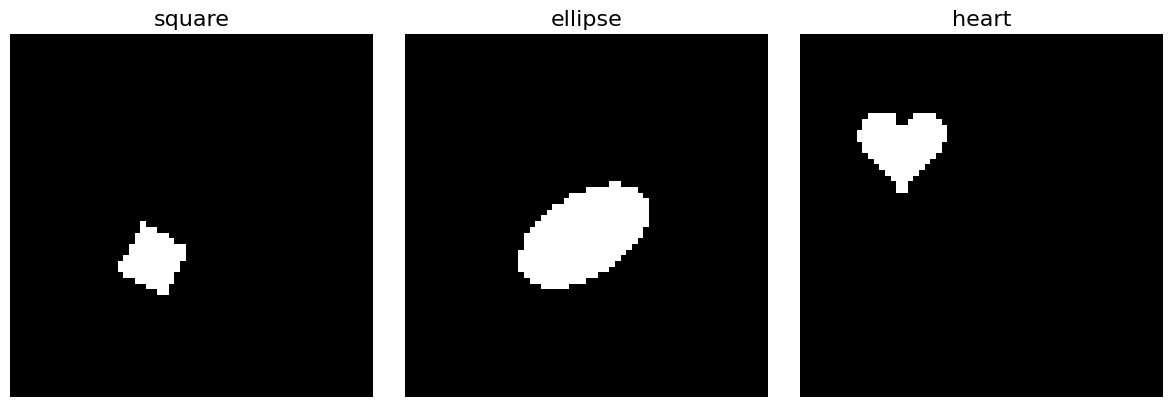

In [11]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters and constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NPZ_FILE = "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
SAVE_PATH = "./lambda_beta_vae_results/"
LATENT_DIM = 10  # Dimensionality of the latent space
BATCH_SIZE = 64  # Batch size for training and validation
LEARNING_RATE = 1e-4  # Learning rate for the optimizer
NUM_EPOCHS = 100  # Number of training epochs
BETAS = [0.1, 0.5, 1, 2, 4, 6, 8]  # Different beta values for beta-VAE
LAMBDAS = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Load dataset
dataset = DspritesDataset(NPZ_FILE)

# Ensure the results directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Define file paths for the indices
train_indices_file = os.path.join(SAVE_PATH, "train_indices.npy")
val_indices_file = os.path.join(SAVE_PATH, "val_indices.npy")

# Split the dataset
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Check if saved indices exist for a consistent split across runs
if os.path.exists(train_indices_file) and os.path.exists(val_indices_file):
    # Load saved indices using numpy
    train_indices = np.load(train_indices_file)
    val_indices = np.load(val_indices_file)
else:
    # Save the indices for reproducibility
    train_indices, val_indices = torch.utils.data.random_split(
        range(len(dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(SEED)
    )

    # Save indices using numpy
    np.save(train_indices_file, train_indices)
    np.save(val_indices_file, val_indices)

# Create subsets using saved indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Select distinct shape indices (square, ellipse, heart) from the validation dataset
distinct_shape_indices = select_3_distinct_shape_indices(val_dataset, list(range(val_size)))
visualize_3_images_from_shapes(val_dataset, distinct_shape_indices)

In [ ]:
# Main script execution
if __name__ == '__main__':
    main()